In [8]:
import pandas as pd
import numpy as np
from itertools import cycle

from sklearn import metrics

from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt

In [6]:
import os
os.p

<module 'posixpath' from '/home/quantiphi/anaconda3/lib/python3.7/posixpath.py'>

In [63]:
# loading train data
train = pd.read_csv('car_breakdown_prediction-develop/train_2.csv')
# loading test data
test = pd.read_csv('car_breakdown_prediction-develop/test_2.csv')

In [66]:
# loading training and testing labels
y_train = train['label_bc']
y_test = test['label_bc']

In [65]:
# 25 ground true positive values(RUL<=30) and 75 ground true negative values(RUL>30)
y_test.value_counts()

0    75
1    25
Name: label_bc, dtype: int64

In [4]:
# original features
features_orig = ['ecoMode','cityMode','sportMode','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['ecoMode','cityMode','sportMode', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20',
                 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14'
                 , 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 
                 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

In [76]:
# scaling the features
X_train = train[features_extr]

X_test = test[features_extr] 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
def bin_classify(model, clf, features, params=None, score=None):
    
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores
    
    """
    
    
    X_train = train[features]

    X_test = test[features] 
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    if(model!='Logistic Regression B'):
        plt.figure(figsize=(40,20))
        plt.bar(features,grid_search.best_estimator_.feature_importances_)
        plt.show()
    
    return grid_search,grid_search.best_estimator_, df_predictions

In [84]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold
        
    """
      
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')
        

    return  df_metrics, df_roc_thresh, df_prc_thresh

In [85]:
def ks_table(X,y,model):
    score = pd.DataFrame()
    top_in = pd.DataFrame()
    bottom_in = pd.DataFrame()
    # model = pickle_load(model)
    if model!=None:
        y_phat = pd.DataFrame(model.predict_proba(X),index = y.index)
        results  = pd.concat([y_phat,y],axis=1)
        results["pred"]=results[1]*1000
    elif score.shape[0]>0:
        results  = pd.concat([score,y],axis=1)
        results["pred"]=score
    else:
        return None
    results["bad"] = y
    cumbad = results["bad"].sum()
    cumtot = results["bad"].count()
    cumgood = cumtot-cumbad

    if top_in.shape[0]==0:
        top = []
        bottom = []
        for i in range(0,20):
          bottom.append(results["pred"].quantile(i/20.00))
          top.append(results["pred"].quantile((i+1)/20.00))
        check = pd.DataFrame(data=[bottom,top]).transpose()
    else:
        top = top_in
        bottom = bottom_in
        check = pd.DataFrame(data=[bottom,top]).transpose()
    check.columns = ["low","high"]

#     check = check.loc[check['low']!=check['high']]
    check["total"] = check["low"]
    check["bad"] = check["low"]
    check = check.sort_values(["high"],ascending = False)

    for index, rows in check.iterrows():
      rows["total"] = results.loc[(results["pred"]>=rows["low"]) & (results["pred"]<rows["high"])]["bad"].count()
      rows["bad"] = results.loc[(results["pred"]>=rows["low"]) & (results["pred"]<rows["high"])]["bad"].sum()

    check['low'] = np.around(check['low'], decimals=0)
    check['high'] = np.around(check['high'], decimals=0)
    check = check.loc[check["total"]!=0]
    check["good"] = check["total"] - check["bad"]
    check["bad_perc"] = check["bad"]/cumbad
    check["good_perc"] = check["good"]/cumgood
    check["pop_perc"] = check["total"]/cumtot
    check["cum_bad"] = check["bad"].cumsum()
    check["cum_good"] = check["good"].cumsum()
    check["cum_tot"] = check["total"].cumsum()
    check["capture_rate"] = check["bad_perc"].cumsum()
#     check["capture_rate"] = check["cum_tot"]/cumtot
    check["pop_rate"] = check["pop_perc"].cumsum()
    check["ibr"] = check["bad"]/check["total"]
    check["KS"] = abs(check["cum_bad"]/cumbad- check["cum_good"]/cumgood)
    KS = check["KS"].max()
    return check, KS

def ks_eval(value):
    print(value)
    for i in ('bad_perc', 'pop_perc', 'ibr', 'KS', 'capture_rate', 'pop_rate'):
        plt.plot(value[0][i], label='Train_' + str(i))
        plt.legend()
        plt.title(i)
        plt.show()


BestParameters:
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
           Logistic Regression B
Accuracy                0.920000
Precision               0.947368
Recall                  0.720000
F1 Score                0.818182
ROC A

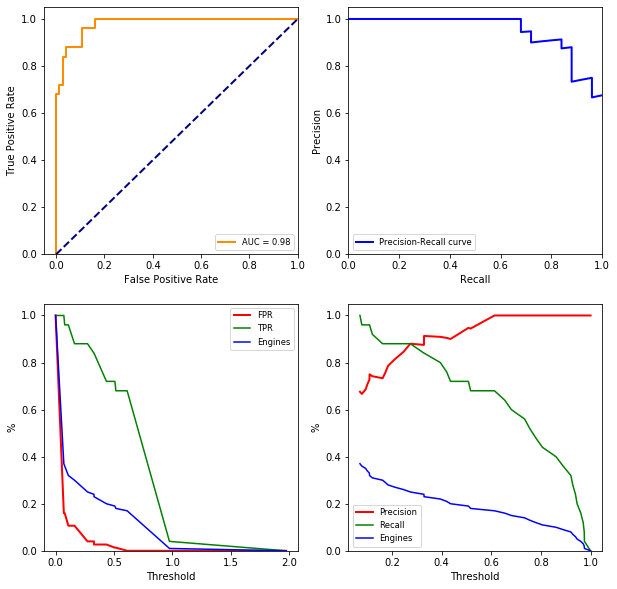

In [87]:
# model-1 logistic regression
model = 'Logistic Regression B'
clf_lgrb = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf,clf_lgrb, pred_lgrb = bin_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score)
print('\nBestParameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = bin_class_metrics(model, y_test, pred_lgrb.y_pred, pred_lgrb.y_score, print_out=True, plot_out=True)

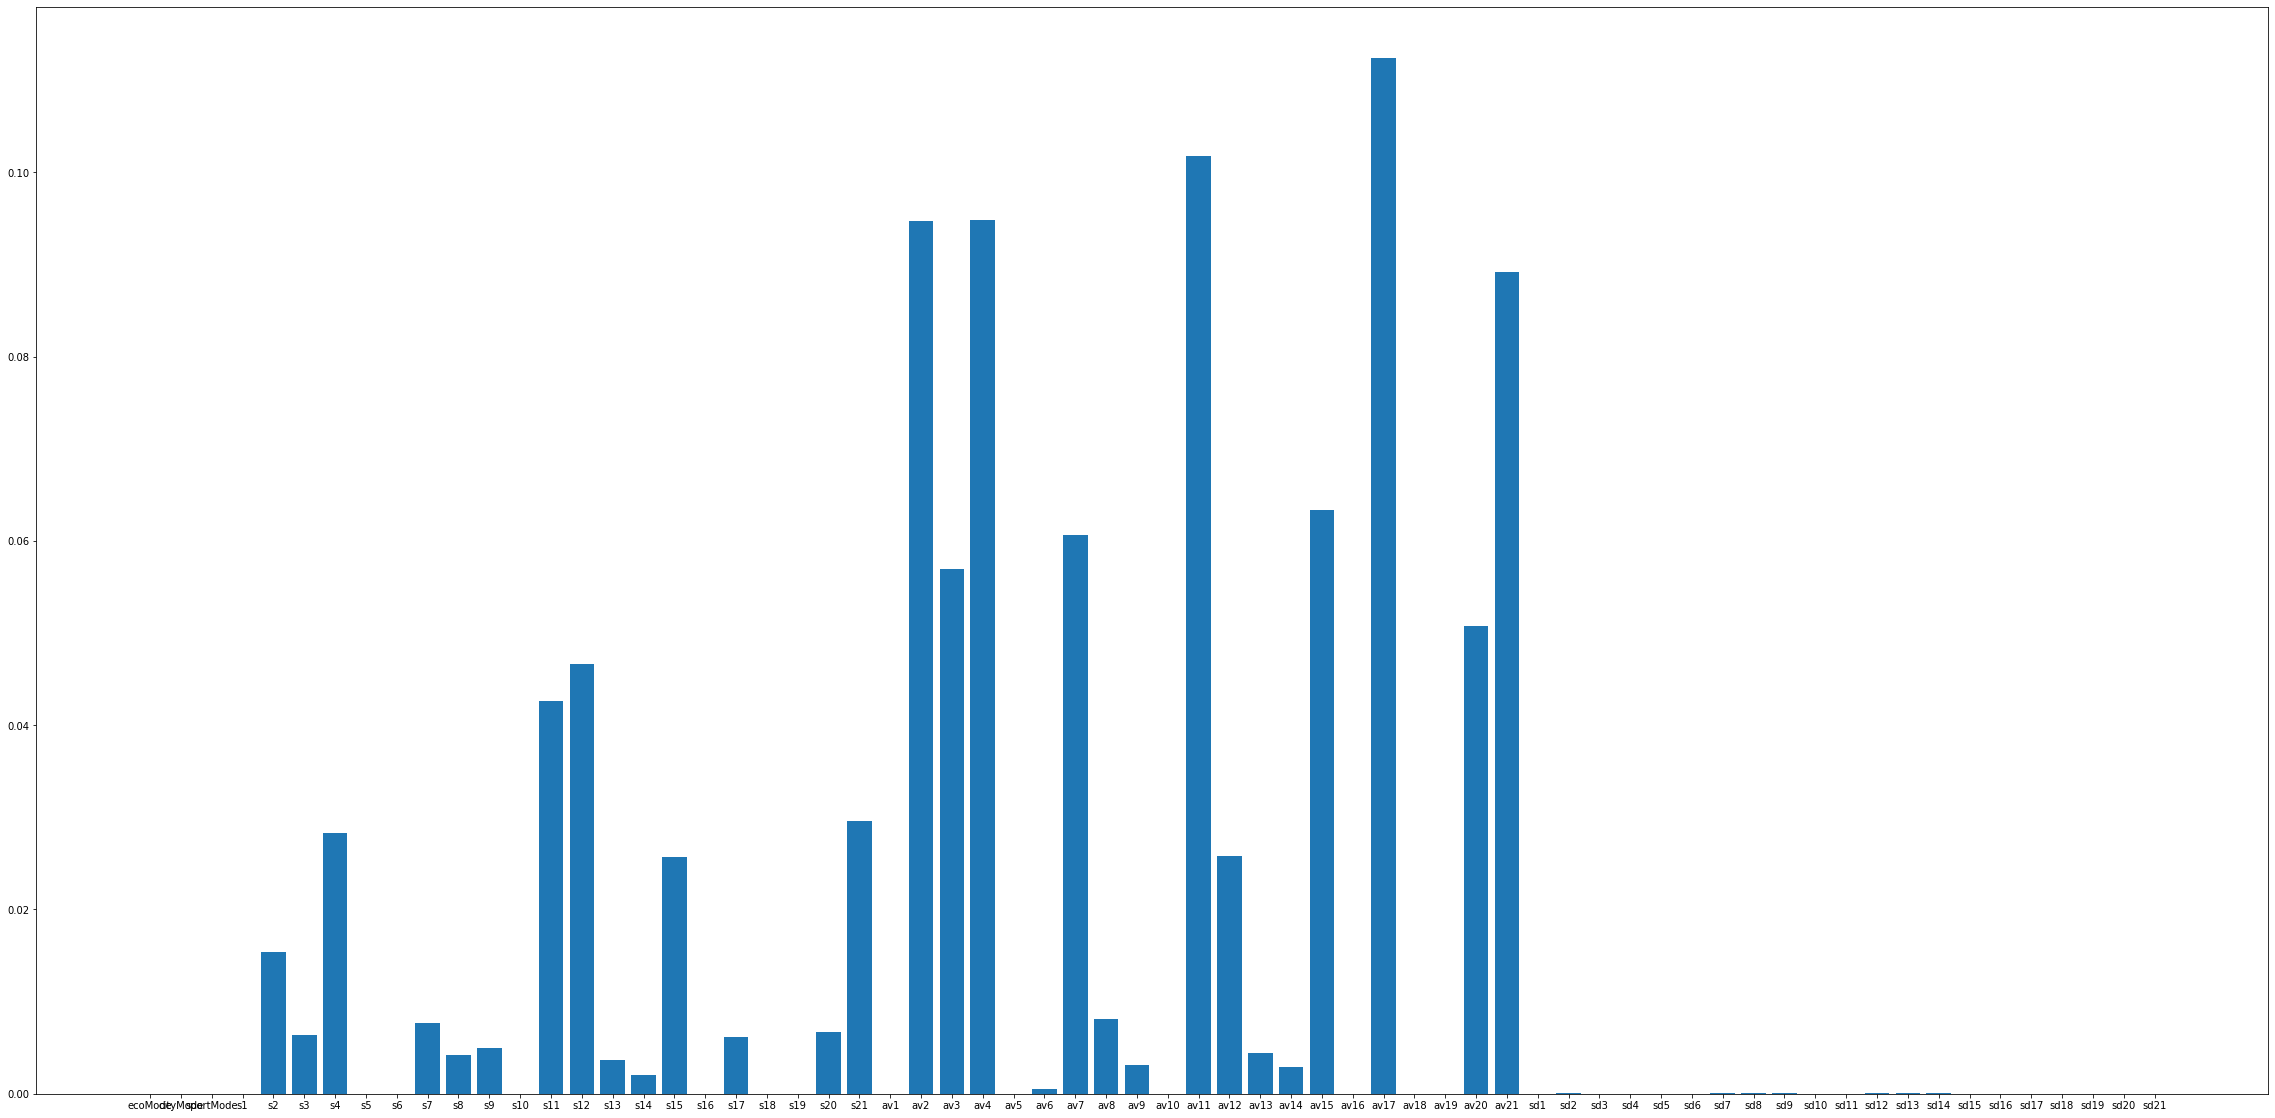


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.05,
                       min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[67  8]
 [ 4 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        75
           1       0.72      0.84      0.78        25

    accuracy                           0.88       100
   macro avg       0.83      0.87      0.85       100
weighted avg       0.89      0.88      0.88       100


Metrics:
    

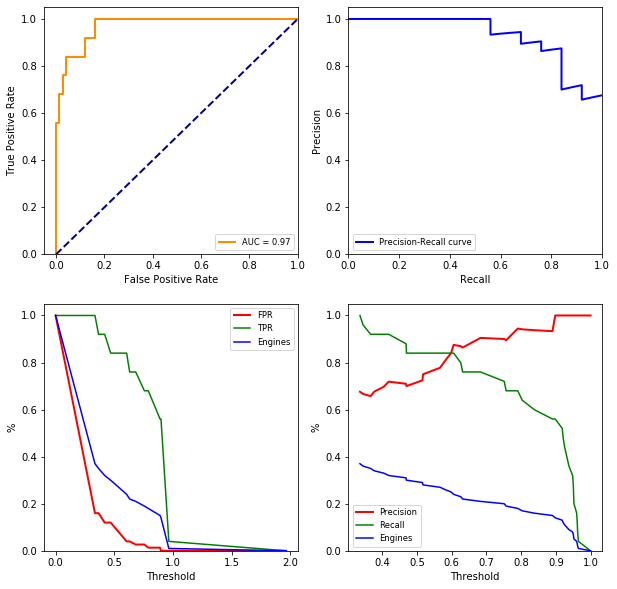

In [75]:
# model_2 RANDOM FOREST
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123,class_weight='balanced')
gs_params = {'max_depth': [5,8,10], 'criterion': ['entropy'],'n_estimators' : [50,100,150],'min_samples_split' : [0.1,0.05],'min_samples_leaf':[0.1,0.05],'max_features':['auto','log2']}
gs_score = 'roc_auc'
clf,clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)

In [77]:
# loading ks_table for train and test dataset
ks_train_rgb = ks_table(X_train, y_train, model=clf)
ks_test_rgb = ks_table(X_test, y_test, model=clf)

In [ ]:
# ks_table for training data giving us the statistics across prediction probability
# columns description
# low - lower bound of quantile
# high - upper bound of quantile
# total - population size in each bin
# bad - how many of them were bad
# good - how many of them were good
# bad_perc - bad/total_no_of_bad
# good_perc - good/total_no_of_good
# pop_perc - pop_in_that_range/total_population
# cum_bad - cummulative sum of bad
# cum_good - cummulative sum of good
# cum_total - cummulative sum of population in each bin
# capture_rate - cummulative bad_perc
# pop_rate - cummulative pop_perc
# ibr - bad/total
# ks - cum_bad/total_no_of_bad- cum_good/total_no_of_good

(      low   high   total     bad    good  bad_perc  good_perc  pop_perc  \
19  952.0  969.0  1031.0  1029.0     2.0  0.331935   0.000114  0.049973   
18  891.0  952.0  1032.0   953.0    79.0  0.307419   0.004506  0.050022   
17  753.0  891.0  1031.0   635.0   396.0  0.204839   0.022589  0.049973   
16  582.0  753.0  1032.0   303.0   729.0  0.097742   0.041583  0.050022   
15  398.0  582.0  1031.0   122.0   909.0  0.039355   0.051851  0.049973   
14  260.0  398.0  1032.0    50.0   982.0  0.016129   0.056015  0.050022   
13  173.0  260.0  1031.0     7.0  1024.0  0.002258   0.058411  0.049973   
12  117.0  173.0  1032.0     0.0  1032.0  0.000000   0.058867  0.050022   
11   79.0  117.0  1031.0     0.0  1031.0  0.000000   0.058810  0.049973   
10   51.0   79.0  1032.0     0.0  1032.0  0.000000   0.058867  0.050022   
9    33.0   51.0  1031.0     0.0  1031.0  0.000000   0.058810  0.049973   
8    22.0   33.0  1032.0     0.0  1032.0  0.000000   0.058867  0.050022   
7    13.0   22.0  1031.0

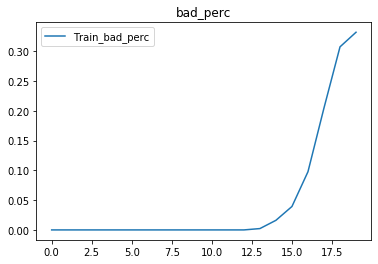

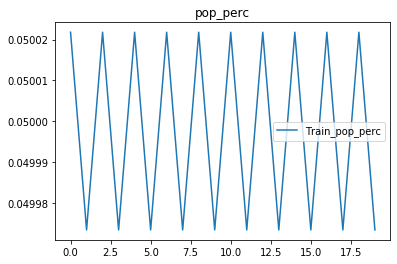

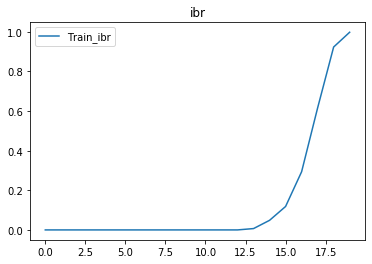

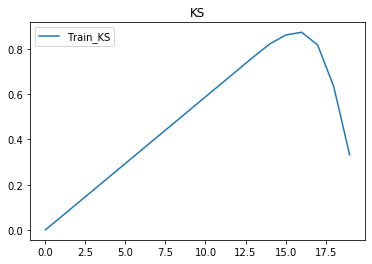

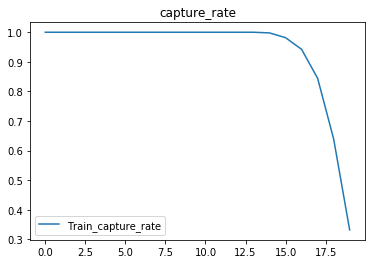

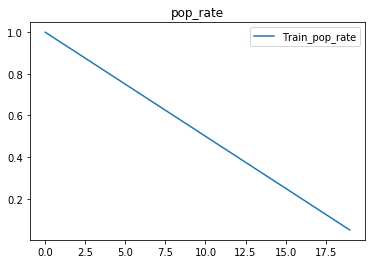

In [78]:
ks_eval(ks_train_rgb)

(      low   high  total  bad  good  bad_perc  good_perc  pop_perc  cum_bad  \
19  951.0  965.0    4.0  4.0   0.0      0.16   0.000000      0.04      4.0   
18  926.0  951.0    5.0  5.0   0.0      0.20   0.000000      0.05      9.0   
17  846.0  926.0    5.0  4.0   1.0      0.16   0.013333      0.05     13.0   
16  697.0  846.0    5.0  4.0   1.0      0.16   0.013333      0.05     17.0   
15  585.0  697.0    5.0  3.0   2.0      0.12   0.026667      0.05     20.0   
14  469.0  585.0    5.0  0.0   5.0      0.00   0.066667      0.05     20.0   
13  352.0  469.0    5.0  2.0   3.0      0.08   0.040000      0.05     22.0   
12  279.0  352.0    5.0  2.0   3.0      0.08   0.040000      0.05     24.0   
11  170.0  279.0    5.0  0.0   5.0      0.00   0.066667      0.05     24.0   
10   80.0  170.0    5.0  0.0   5.0      0.00   0.066667      0.05     24.0   
9    64.0   80.0    5.0  0.0   5.0      0.00   0.066667      0.05     24.0   
8    48.0   64.0    5.0  0.0   5.0      0.00   0.066667      0.

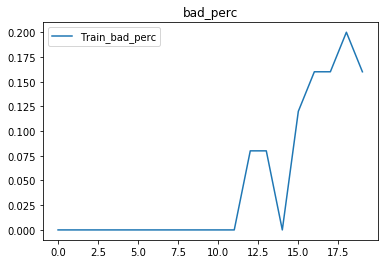

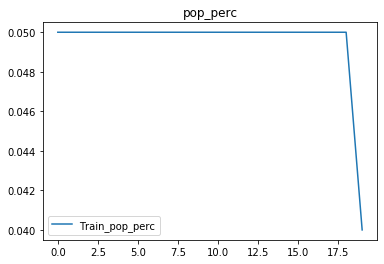

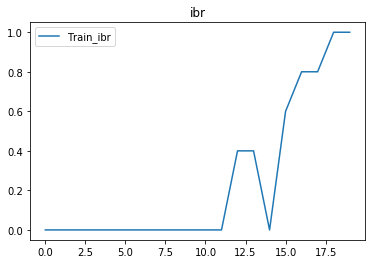

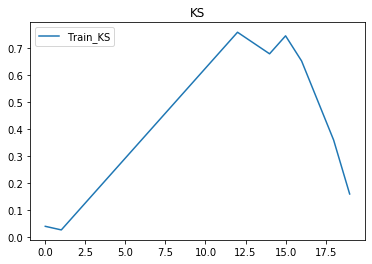

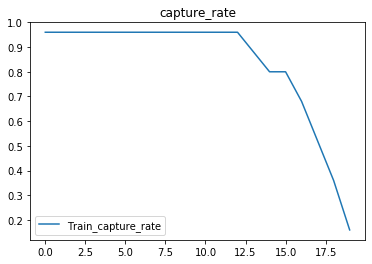

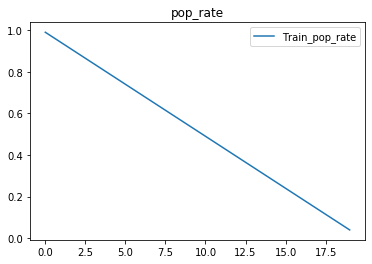

In [79]:
ks_eval(ks_test_rgb)

In [80]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

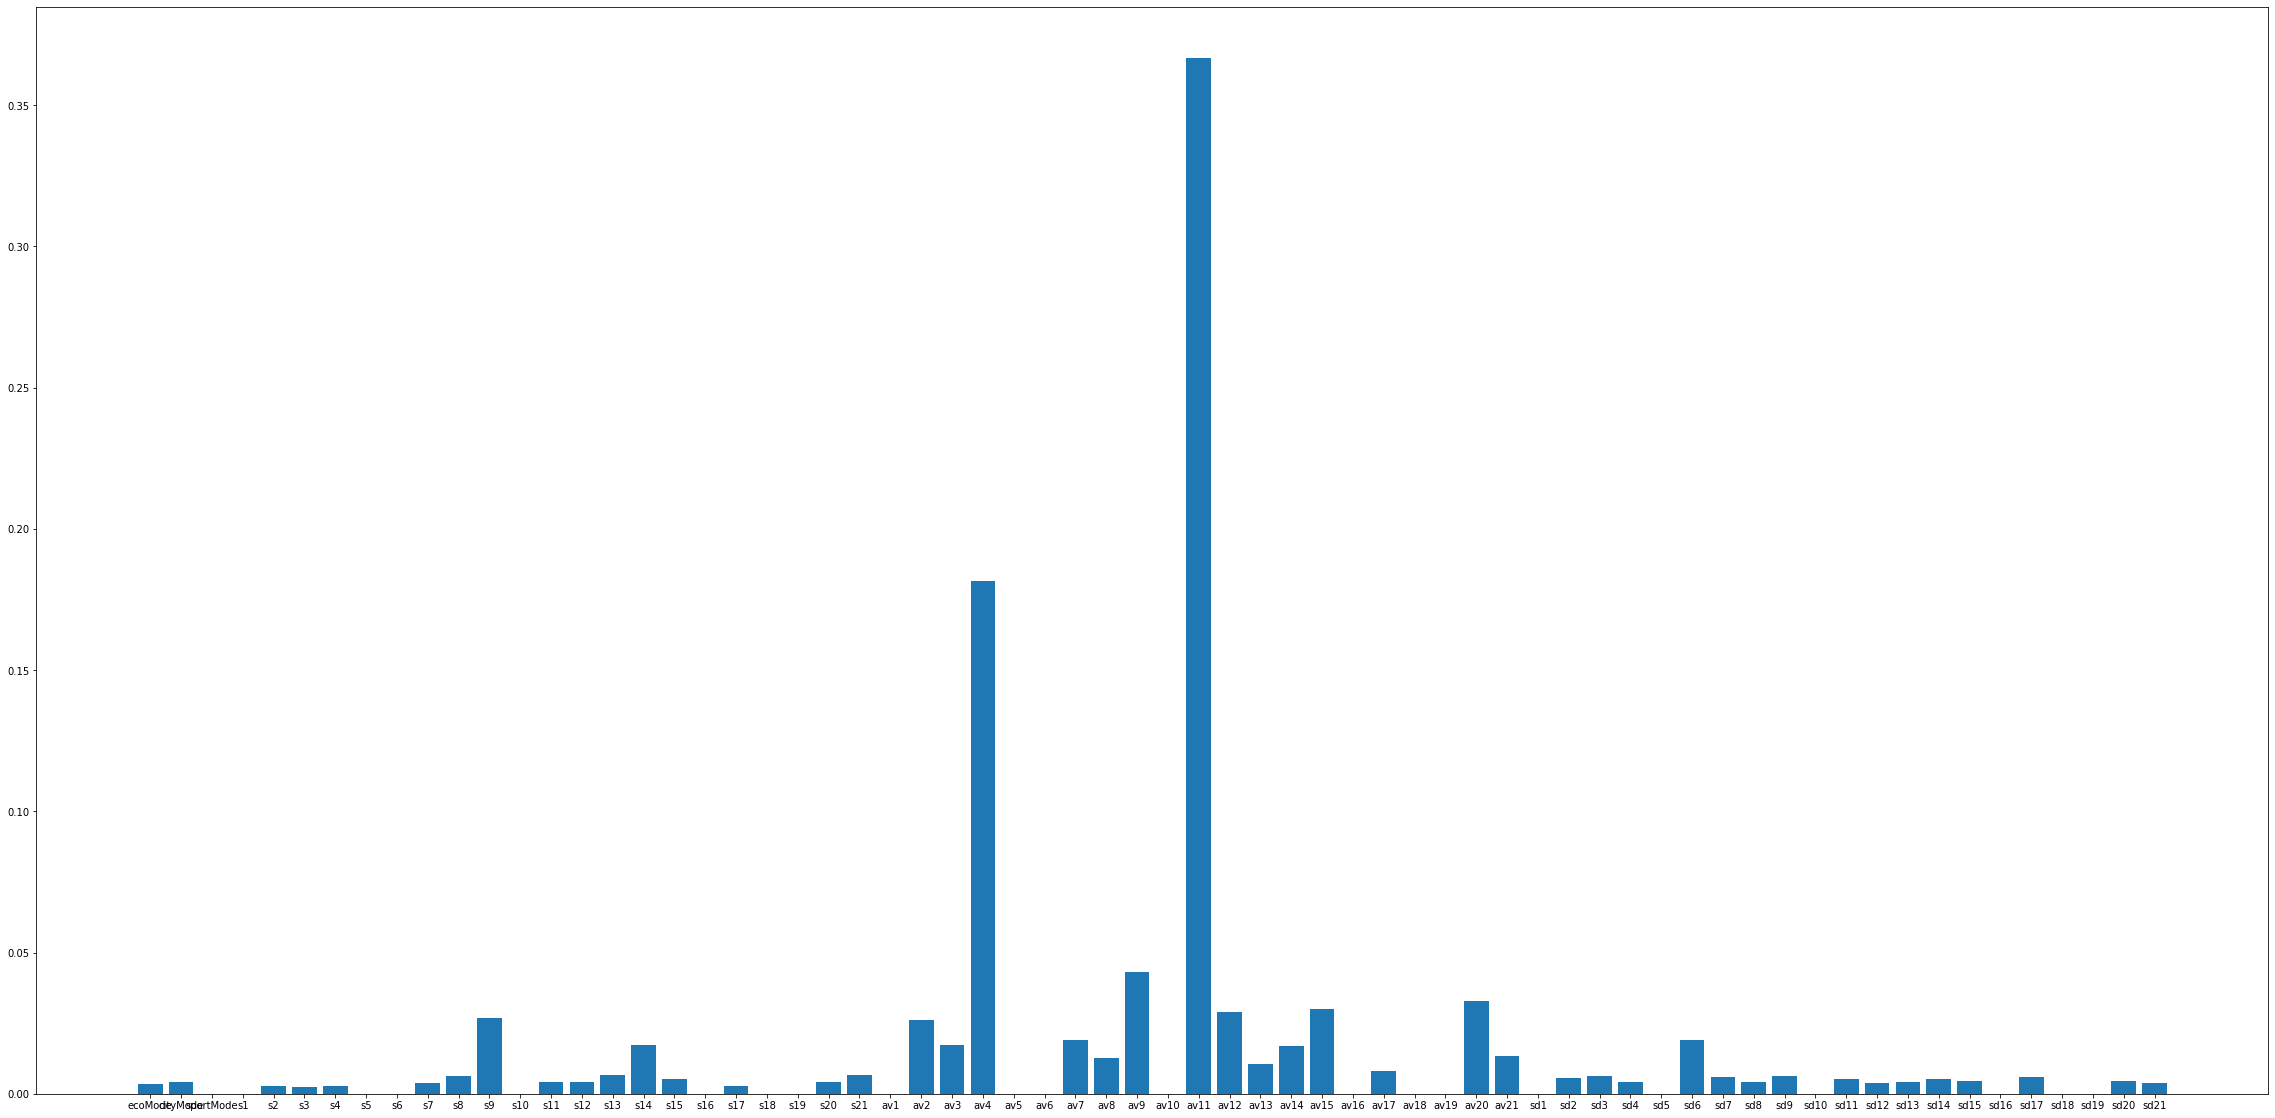


Best Parameters:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
-----------------------------------------------------------
XGBOOST B 

Confusion Matrix:
[[74  1]
 [ 6 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95        75
           1       0.95      0.76      0.84        25

    accuracy                           0.93       100
   macro avg       0.94      0.87      0.90       100
weighted avg       0.93      0.93      0.93       100


Metrics:
           XGBOOST B
Accuracy    0.930

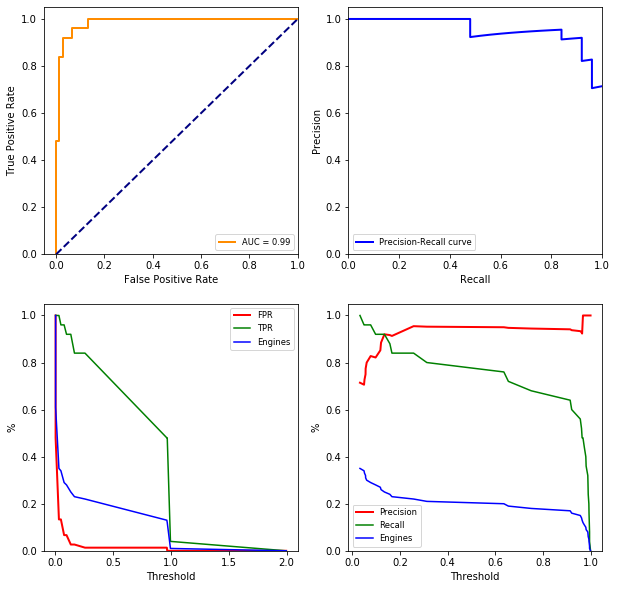

In [81]:
# model_3 xgboost
# Parameter tuning
model = 'XGBOOST B'
clf_xgb =XGBClassifier(learning_rate=0.05, n_estimators=100)
param_test = {
'subsample':[0.6,0.8,0.9,1],
'n_estimators':[100,200],
'max_depth':[5,7]
}
gs_score = 'roc_auc'
clf,clf_xgb, pred_rfcb = bin_classify(model, clf_xgb, features_extr, params=param_test, score=gs_score)
print('\nBest Parameters:\n',clf_xgb)

metrics_xgb, roc_xgb, prc_xgb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)

In [88]:
# fitting first model clf
params={
    'n_estimators':200,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.8,
    'subsample':0.6,
    'colsample_bytree':1,
    'min_child_weight':1,
    'max_depth':5,
    'seed':1024,
    'nthread':4,
    'scale_pos_weight':1,
    'seed':271 
}

clf = XGBClassifier(**params)
clf.fit(X_train, y_train, \
        eval_set=[(X_train, y_train), (X_test, y_test)], \
                  eval_metric='auc', early_stopping_rounds = 50)
clf.best_ntree_limit
clf.set_params(**{'n_estimators': clf.best_ntree_limit})
# clf.fit(X_train.values, y_train)

[0]	validation_0-auc:0.984619	validation_1-auc:0.941067
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.988893	validation_1-auc:0.970933
[2]	validation_0-auc:0.992234	validation_1-auc:0.970667
[3]	validation_0-auc:0.992426	validation_1-auc:0.9728
[4]	validation_0-auc:0.992644	validation_1-auc:0.974933
[5]	validation_0-auc:0.993003	validation_1-auc:0.9784
[6]	validation_0-auc:0.993498	validation_1-auc:0.9816
[7]	validation_0-auc:0.993694	validation_1-auc:0.983733
[8]	validation_0-auc:0.993993	validation_1-auc:0.982933
[9]	validation_0-auc:0.99404	validation_1-auc:0.9824
[10]	validation_0-auc:0.994114	validation_1-auc:0.985067
[11]	validation_0-auc:0.994163	validation_1-auc:0.984
[12]	validation_0-auc:0.99425	validation_1-auc:0.983467
[13]	validation_0-auc:0.994323	validation_1-auc:0.984533
[14]	validation_0-auc:0.994566	validation_1-auc:0.983467
[15]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.8,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=48, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=271,
              silent=None, subsample=0.6, verbosity=1)

In [89]:
ks_train_xgb = ks_table(X_train, y_train, model=clf)
ks_test_xgb = ks_table(X_test, y_test, model=clf)

(      low   high    total     bad     good  bad_perc  good_perc  pop_perc  \
19  950.0  955.0   1031.0  1031.0      0.0  0.332581   0.000000  0.049973   
18  895.0  950.0   1032.0  1032.0      0.0  0.332903   0.000000  0.050022   
17  411.0  895.0   1031.0   807.0    224.0  0.260323   0.012777  0.049973   
16  141.0  411.0   1032.0   193.0    839.0  0.062258   0.047858  0.050022   
15   74.0  141.0   1031.0    32.0    999.0  0.010323   0.056985  0.049973   
14   54.0   74.0   1032.0     4.0   1028.0  0.001290   0.058639  0.050022   
13   48.0   54.0   1032.0     0.0   1032.0  0.000000   0.058867  0.050022   
12   46.0   48.0   1031.0     0.0   1031.0  0.000000   0.058810  0.049973   
11   45.0   46.0  12377.0     0.0  12377.0  0.000000   0.706007  0.599922   
0    45.0   45.0      1.0     0.0      1.0  0.000000   0.000057  0.000048   

    cum_bad  cum_good  cum_tot  capture_rate  pop_rate       ibr        KS  
19   1031.0       0.0   1031.0      0.332581  0.049973  1.000000  0.332581

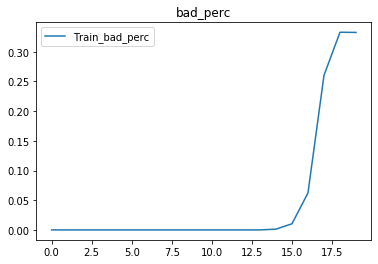

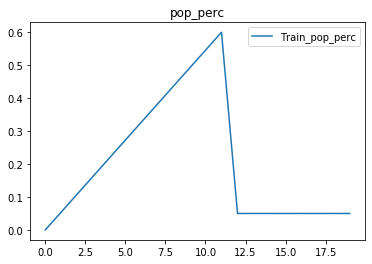

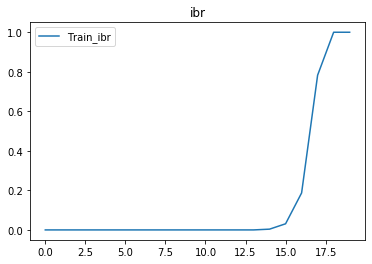

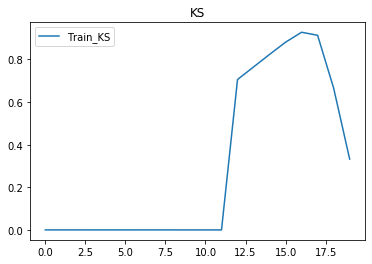

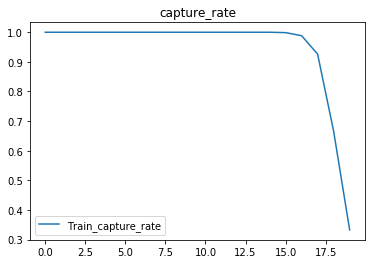

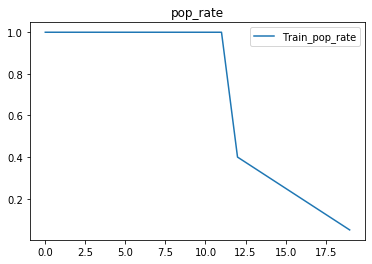

In [90]:
ks_eval(ks_train_xgb)

(      low   high  total  bad  good  bad_perc  good_perc  pop_perc  cum_bad  \
19  944.0  954.0    3.0  3.0   0.0      0.12   0.000000      0.03      3.0   
18  921.0  944.0    5.0  5.0   0.0      0.20   0.000000      0.05      8.0   
17  852.0  921.0    5.0  4.0   1.0      0.16   0.013333      0.05     12.0   
16  357.0  852.0    5.0  5.0   0.0      0.20   0.000000      0.05     17.0   
15  148.0  357.0    5.0  4.0   1.0      0.16   0.013333      0.05     21.0   
14  109.0  148.0    5.0  1.0   4.0      0.04   0.053333      0.05     22.0   
13   82.0  109.0    5.0  1.0   4.0      0.04   0.053333      0.05     23.0   
12   50.0   82.0    5.0  0.0   5.0      0.00   0.066667      0.05     23.0   
11   48.0   50.0    5.0  0.0   5.0      0.00   0.066667      0.05     23.0   
10   46.0   48.0    5.0  0.0   5.0      0.00   0.066667      0.05     23.0   
9    45.0   46.0   50.0  0.0  50.0      0.00   0.666667      0.50     23.0   

    cum_good  cum_tot  capture_rate  pop_rate  ibr        KS  

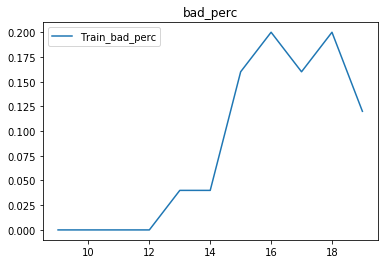

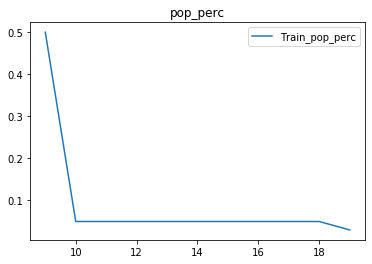

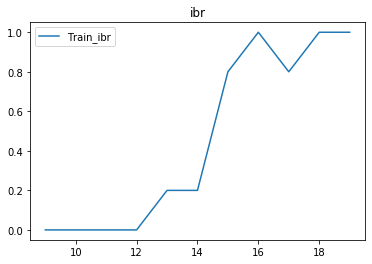

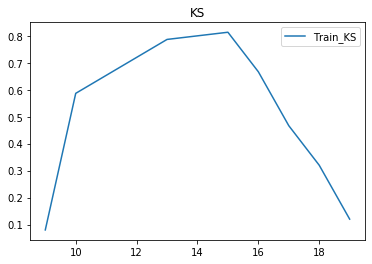

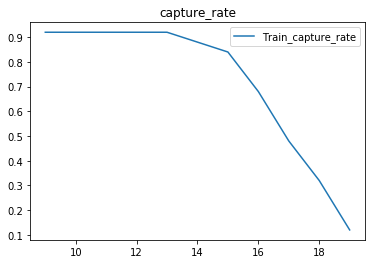

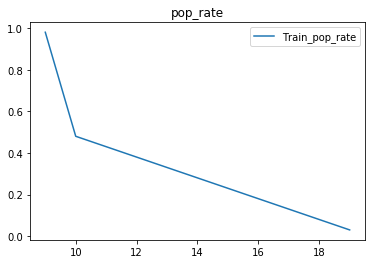

In [91]:
ks_eval(ks_test_xgb)